#Import packages

In [2]:
from base_pipeline_v2 import *
import os
import scanpy as sc
import numpy as np
import pandas as pd
import pegasusio as io

Load toy dataset

In [3]:
savepath='/projects/home/aantoinette/pipeline_test120424/'
os.makedirs(savepath, exist_ok=True)

adata = sc.read('/projects/Blood_Cell_Atals/Disease_results/=Final_disease_objects/Final_clean/Thyroid_Annotated.h5ad')

n_cells = 50000  
seed = 42  
np.random.seed(seed)
downsample_indices = np.random.choice(adata.n_obs, n_cells, replace=False)
adata = adata[downsample_indices].copy()

data = adata.copy()
data = io.MultimodalData(data)
data.X = data.get_matrix('raw.X')

adata.layers['raw.X'] = data.X
adata.X = adata.layers['raw.X'].copy()
print(adata.X[0:10])

  (0, 55)	1.0
  (0, 66)	1.0
  (0, 152)	1.0
  (0, 154)	3.0
  (0, 190)	3.0
  (0, 244)	1.0
  (0, 259)	1.0
  (0, 326)	1.0
  (0, 381)	1.0
  (0, 493)	5.0
  (0, 497)	1.0
  (0, 500)	1.0
  (0, 521)	1.0
  (0, 526)	1.0
  (0, 528)	1.0
  (0, 531)	1.0
  (0, 559)	4.0
  (0, 561)	4.0
  (0, 587)	1.0
  (0, 597)	1.0
  (0, 630)	1.0
  (0, 643)	1.0
  (0, 651)	1.0
  (0, 670)	1.0
  (0, 682)	1.0
  :	:
  (9, 33207)	2.0
  (9, 33215)	1.0
  (9, 33248)	1.0
  (9, 33257)	1.0
  (9, 33279)	1.0
  (9, 33297)	2.0
  (9, 33322)	1.0
  (9, 33326)	2.0
  (9, 33355)	1.0
  (9, 33364)	1.0
  (9, 33443)	1.0
  (9, 33445)	1.0
  (9, 33447)	2.0
  (9, 33496)	3.0
  (9, 33497)	5.0
  (9, 33498)	6.0
  (9, 33499)	23.0
  (9, 33500)	3.0
  (9, 33501)	6.0
  (9, 33502)	4.0
  (9, 33503)	4.0
  (9, 33504)	7.0
  (9, 33505)	5.0
  (9, 33506)	2.0
  (9, 33508)	4.0


#check adata
#check if obs contains sample_id, Disease, Chemistry, Technology, Batch
#check if var contains symbol
#check if layers contains raw.X
#tell the user which one to add

In [5]:
check_adata_integrity(adata)

Missing columns in 'adata.obs': Technology. Please add them.
All required items are present in 'adata.var'.
All required layers are present in 'adata.layers'.


In [6]:
adata.var['symbol'] = adata.var.index

#qc and filtering

In [7]:
qc_filtering(data=adata, min_genes=500, pct_mito=20,savepath=savepath,
             dataset_name='test_data', group='sample_id')

View of AnnData object with n_obs × n_vars = 41896 × 33538
    obs: 'Disease', 'Batch', 'SubBatch', 'sample_id', 'Chemistry', 'Protocol', 'Sequencing_Pool', 'n_genes', 'n_counts', 'percent_mito', 'Barcode', 'Lineage', 'ANNOT_0', 'ANNOT_1', 'sum_mito_UMIs', 'sum_UMIs'
    var: 'symbol', 'mt'
    uns: 'ANNOT_0_colors', 'ANNOT_1_colors', 'Channel_colors', 'Lineage_colors', 'log1p', 'modality'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_before_harmony', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices', 'pca_knn_distances', 'pca_knn_indices'
    layers: 'raw.X'

In [8]:
#normalization

In [9]:
adata = normalize(adata)

#filtering before hvg selection

In [11]:

additional_pattern_list = [
    r"^AB\d+\.", r"^AC\d+\.", r"^AD\d+\.", r"^AF\d+\.", r"^AJ\d+\.", r"^AL\d+\.", r"^AP\d+\.",
    r"^BX\d+\.",
    r"^CR\d+\.", r"^CU\d+\.",
    r"^F\d+\.", r"^FP\d+\.", r"^FO\d+\.",
    r"^KF\d+\.", r"^KC\d+\.",
    r"^L\d+\.",
    r"^LINC",
    r"^MTRN",
    r"^RP\d+-",
    r"^U\d+\.",
    r"^Z\d+\."
]

#this in hvg functions editing folder
selected_adata, exclude_genes = remove_genes_for_HVG(
    adata,
    TCR=True,
    BCR=True,
    ribosomal=True,
    mitochondrial=True,
    low_quality=True,
    sex=True,
    additional_pattern=additional_pattern_list
)


****** Filtering genes for feature selection...


In [12]:
#del adata to save memory
del adata

In [13]:
#hvg
lineage = 'all'
group_by='Disease'
bin_path = '/projects/blood_cell_atlas/bin/'
save_dir = savepath
batch_key = 'Batch'

feature_selection(selected_adata,group_by,batch_key, bin_path, lineage,
                  save_dir, min_number_cells=5, HVG_min_mean=0.01, HVG_min_disp=0.5)

****** Filtering genes for feature selection...
****** Computing highly variable genes...
Thyroid_Control
Hashimotos
Graves
Total number of genes selected as HV in at least one disease: 2347


/projects/home/aantoinette/base_pipeline_v2/base_pipeline_v2/qc_normalization_featureselection_exp.py:185: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['highly_variable'] = False


IndexError: list index out of range

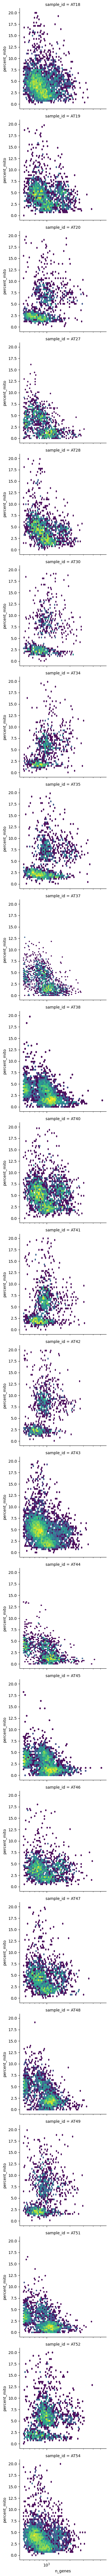

In [18]:
def create_hexbin_plot(data, dataset_name='',group='', savepath='', axlines=[], col_wrap=1):
    #print('hello')
    import seaborn as sns
    # fig, ax = plt.subplots(figsize=(4*len(set(data.obs[group])),4))
    g = sns.FacetGrid(data.obs, col=group, col_wrap=col_wrap,
                      height=4, aspect=1)
    g.map(plt.hexbin, 'n_genes', 'percent_mito', bins='log',
          gridsize=50, xscale='log', edgecolors='none', linewidths=0)
    for ax in g.axes.flat:
        ax.axhline(y=axlines[1], color='red', linestyle='--')
        ax.axvline(x=axlines[0], color='red', linestyle='--')
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.xaxis.set_tick_params(labelbottom=True)

        # Add axis labels and a title
    g.set_axis_labels('Number of Genes', 'Percent Mito')
    # g.fig.suptitle('Hexbin plot of gene count vs percent mitochondrial reads by sample', wrap=True)
    plt.tight_layout()
    # Save the figure
    #plt.show()
    plt.savefig(savepath+'/'+dataset_name+ group+'_hexbin_plot.png')
    plt.show()
    
create_hexbin_plot(adata, dataset_name='t',group='sample_id', savepath=savepath)

In [14]:
#subset anndata using hvgs
adata = selected_adata.copy()
adata = adata[:, adata.var['highly_variable'] == True]

In [15]:
#optimal pc calculations to use with harmony, bbkknn and/or scanorama
adata.var['highly_variable_features'] = adata.var['highly_variable']
optimal_pcs= run_mcv_functions_sc(adata, savepath,raw_name='raw.X')
adata.uns['optimal_pcs']= optimal_pcs
optimal_pcs = adata.uns['optimal_pcs']


/tmp/ipykernel_313977/3776987476.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['highly_variable_features'] = adata.var['highly_variable']


2024-12-04 22:06:05,013 - pegasus.tools.preprocessing - INFO - After filtration, 2347/2347 genes are kept. Among 2347 genes, 2345 genes are robust.
2024-12-04 22:06:05,046 - pegasus.tools.preprocessing - INFO - Function 'identify_robust_genes' finished in 3.02s.
2024-12-04 22:06:05,313 - pegasus.tools.preprocessing - INFO - Function 'log_norm' finished in 0.27s.
2024-12-04 22:06:05,523 - pegasus.tools.hvf_selection - INFO - Function 'estimate_feature_statistics' finished in 0.21s.
2024-12-04 22:06:05,640 - pegasus.tools.hvf_selection - INFO - 2000 highly variable features have been selected.
2024-12-04 22:06:05,657 - pegasus.tools.hvf_selection - INFO - Function 'highly_variable_features' finished in 0.34s.
2024-12-04 22:06:07,913 - pegasus.tools.preprocessing - INFO - After filtration, 2347/2347 genes are kept. Among 2347 genes, 2345 genes are robust.
2024-12-04 22:06:07,914 - pegasus.tools.preprocessing - INFO - Function 'identify_robust_genes' finished in 2.25s.
2024-12-04 22:06:08,

100%|██████████| 32/32 [14:48<00:00, 27.78s/it]


In [19]:
batch_key= 'Batch'
n_neighbors = 10
#Computing different integration methods

# Using BBKNN integration
bbknn_pipeline = IntegrationPipeline(
    adata, method="bbknn", batch_key=batch_key, n_neighbors=n_neighbors, optimal_pcs=optimal_pcs, hvg='highly_variable'
)
adata_b = bbknn_pipeline.integrate()

# Using Scanorama integration
scanorama_pipeline = IntegrationPipeline(
    adata, method="scanorama", batch_key=batch_key, n_neighbors=n_neighbors, optimal_pcs=optimal_pcs, hvg='highly_variable'
)
adata_s = scanorama_pipeline.integrate()

# Using Harmony integration
harmony_pipeline = IntegrationPipeline(
    adata, method="harmony", batch_key=batch_key, n_neighbors=n_neighbors, optimal_pcs=optimal_pcs, hvg='highly_variable'
)
adata_h = harmony_pipeline.integrate()

# Using scVI integration
scvi_pipeline = IntegrationPipeline(
    adata, method="scvi", savepath=savepath,
    epochs=30, discrete_variables=['Batch'], continuous_variables=[], n_layers=2, n_latent=30,
    username_on_dgx='aantoinette', working_directory_dgx='/home/aantoinette/endocrinopathies'
)
adata_scvi = scvi_pipeline.integrate()

****** Performing PCA...


/projects/home/aantoinette/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


****** Running Bbknn integration...
****** Computing UMAP...
****** Performing PCA...


/projects/home/aantoinette/.local/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


****** Running Scanorama integration...
[[0.         0.19901578 0.95451739 0.0425641  0.82192495 0.02939911]
 [0.         0.         0.02099197 0.7425641  0.02102154 0.94077155]
 [0.         0.         0.         0.02487179 0.5616382  0.01872813]
 [0.         0.         0.         0.         0.01692308 0.82128205]
 [0.         0.         0.         0.         0.         0.1143155 ]
 [0.         0.         0.         0.         0.         0.        ]]
Processing datasets AT_Plate1_3P <=> AT_Plate2_3P
Processing datasets AT_Plate1_5P <=> AT_Plate3_5P
Processing datasets AT_Plate1_3P <=> AT_Plate3_3P
Processing datasets AT_Plate2_5P <=> AT_Plate3_5P
Processing datasets AT_Plate1_5P <=> AT_Plate2_5P


KeyboardInterrupt: 

In [ ]:
#Plotting umaps
plot_umap(adata_b, col='ANNOT_0', label='bbknn_test', figsize=(8,6), legend_loc='right margin', savepath=savepath)
plot_obs_feature_on_umap_separately(adata_b, 'Disease', savepath+'Diseasebbknn_umap.png', size=None)

plot_umap(adata_s, col='ANNOT_0', label='scano_test', figsize=(8,6), legend_loc='right margin', savepath=savepath)
plot_obs_feature_on_umap_separately(adata_s, 'Disease', savepath+'Diseasescano_umap.png', size=None)

plot_umap(adata_h, col='ANNOT_0', label='harmony_test', figsize=(8,6), legend_loc='right margin', savepath=savepath)
plot_obs_feature_on_umap_separately(adata_h, 'Disease', savepath+'Diseaseharmony_umap.png', size=None)

plot_umap(adata_scvi, col='ANNOT_0', label='scvi_test', figsize=(8,6), legend_loc='right margin', savepath=savepath)
plot_obs_feature_on_umap_separately(adata_scvi, 'Disease', savepath+'Diseasescvi_umap.png', size=None)

In [ ]:
#Comparing and assessing integration methods
metrics_bbknn = compute_metrics( X=adata_b.obsm["X_umap"], Labels=adata_b.obs['ANNOT_0'].to_numpy(),
                 Batches=adata_b.obs['Batch'].to_numpy(),adata=adata_b, ksim_attr='ANNOT_0', ksim_rep='umap')

metrics_scanorama = compute_metrics( X=adata_s.obsm["X_umap"], Labels=adata_s.obs['ANNOT_0'].to_numpy(),
                 Batches=adata_s.obs['Batch'].to_numpy(), adata=adata_s, ksim_attr='ANNOT_0', ksim_rep='umap')

metrics_harmony = compute_metrics( X=adata_h.obsm["X_umap"], Labels=adata_h.obs['ANNOT_0'].to_numpy(),
                 Batches=adata_h.obs['Batch'].to_numpy(), adata=adata_h, ksim_attr='ANNOT_0', ksim_rep='umap')

metrics_scvi = compute_metrics( X=adata_scvi.obsm["X_umap"], Labels=adata_scvi.obs['ANNOT_0'].to_numpy(),
                 Batches=adata_scvi.obs['Batch'].to_numpy(), adata=adata_scvi, ksim_attr='ANNOT_0', ksim_rep='umap')


met = [metrics_harmony, metrics_scvi, metrics_bbknn, metrics_scanorama]
ind = ['harmony', 'scvi', 'bbknn', 'scanorama']

plot_calc_metrics(met, ind, savepath=None, min_max_scale=True)

In [ ]:
#Computing leiden clusters
list_of_variables_to_check_clusters = ['ANNOT_0', 'Disease']
leiden_res_list = [0.5]
max_cells_plot=100000

#generate_GeneralMarkers_dotplot_per_leiden_cluster=False
generate_GeneralMarkers_dotplot_per_leiden_cluster=True
general_markers = ['CD3D', 'CD4', 'CD8A', "NCAM1",
                       'FOXP3', 'GNLY', 'KLRD1', "NKG7",
                       'MS4A1', 'CD79A', 'TCL1A', 'CD27',
                       'IGHM', 'IGHD', 'IGHG1', 'IGHA1',
                       "JCHAIN", "MZB1", "LILRA4", "IL3RA",
                       'LYZ', 'CD14', 'FCGR3A', "CD1C",
                       "CLEC4C", "CLEC9A", "CLEC10A", "CD34",
                       'PPBP', 'HBB', 'MKI67', "TOP2A"]


#leiden compute
other_vars = ['n_counts', 'n_genes', 'percent_mito']
#compute_leiden_clusters(adata,list_of_variables_to_check_clusters,leiden_res_list, save_dir,other_vars)

compute_leiden_clusters(adata_scvi,list_of_variables_to_check_clusters,leiden_res_list, save_dir,other_vars,
                        neighbors_key=None)
compute_leiden_clusters(adata_h,list_of_variables_to_check_clusters,leiden_res_list, save_dir,other_vars,
                        neighbors_key='harmony')

In [ ]:
#Comparing cluster similarity between methods
adata_h.obs['leiden_res_0.5'].value_counts()
adata_scvi.obs['leiden_res_0.5'].value_counts()
compare_clusters(adata_scvi, adata_h, 'leiden_res_0.5', 'leiden_res_0.5',
                 'scvi', 'harmony', savepath=None)

In [ ]:
#Bring anndata back
adata = sc.read(savepath+'norm_checkpt.h5ad')
adata.obs = adata_h.obs
adata.uns = adata_h.uns
adata.obsm = adata_h.obsm
adata.var['highly_variable'] = adata_h.var['highly_variable']


In [ ]:
#Visualize clusters
list_of_variables_to_check_clusters = ['Disease']
max_cells_plot=100000
visualize_leiden_umap_compo_dotplots(adata, max_cells_plot, leiden_res_list,
                               save_dir,generate_GeneralMarkers_dotplot_per_leiden_cluster,
                               list_of_variables_to_check_clusters, general_markers)


In [ ]:
#Visualize Markers
visualizeDE_markers = ['CD3D', 'CD8A', "NCAM1",
                       'FOXP3', "NKG7",
                       'MS4A1', 'CD79A',
                       "JCHAIN", "LILRA4", "IL3RA",
                       'LYZ', 'CD14', 'FCGR3A', "CD1C",
                       "CLEC4C", "CLEC9A",
                       "CD34"]

leiden_res_list = [0.5]
calc_markers(adata, leiden_res_list, save_dir=savepath,
             compute_markers=True, save_excel=None, visualize_markers=True)

In [ ]:
#Visualize general markers
max_cells_plot=100000
category = 'test_all'
general_markers = ['CD3D', 'CD8A', "NCAM1",
                       'FOXP3', "NKG7",
                       'MS4A1', 'CD79A',
                       "JCHAIN", "LILRA4", "IL3RA",
                       'LYZ', 'CD14', 'FCGR3A', "CD1C",
                       "CLEC4C", "CLEC9A",
                       "CD34"]

adata.obs['leiden_labels'] = adata.obs['leiden_res_0.5']
visualize_general_markers(adata, max_cells_plot=100000, col='leiden_labels',
                        general_markers=general_markers, category='test_all', save_output=None, save_dir=savepath)



In [ ]:
#pseudobulk and DE
for col in adata.var.columns:
    if not pd.api.types.is_string_dtype(adata.var[col]):
        adata.var[col] = adata.var[col].astype(str)

adata = adata[~adata.obs['sample_id'].isna()].copy()
subset_name= 'all_data'
savepath_pb= savepath
adata = io.MultimodalData(adata)
adata.X = adata.X.astype('float32')
adata.obs['leiden_labels'] = adata.obs['leiden_res_0.5'].astype(str)
pg.de_analysis(adata, cluster='leiden_labels')
adata.select_matrix('raw.X')
adata = adata.to_anndata()

# adata.obs['leiden_labels'].value_counts()
# adata.obs['sample_id'].value_counts()

import pseudobulk as pb
pb.pseudobulk.calc_pseudobulk_stats(adata,
                                    save_path=savepath_pb,
                                    save_name=subset_name,
                                    cluster_label="leiden_labels",
                                    sample_label='sample_id',
                                    save_format='h5ad',
                                    write_excel_files=True,
                                    oneAVAtab=True)


In [ ]:
#cell browser
subset_name= 'test'
integrated_df = sc.read(os.path.join(savepath, subset_name) + '.h5ad')
browser_path = os.path.join(savepath, "cellbrowser")
os.makedirs(browser_path, exist_ok=True)

vars = ['auroc',
 'log2Mean',
 'log2Mean_other',
 'log2FC',
 'pseudobulk_log_fold_change',
 'pseudobulk_p_val',
 'pseudobulk_adj_p_val',
 'percentage',
 'percentage_other',
 'percentage_fold_change']

make_kamil_browser(integrated_df,
                   browser_filepath=browser_path,
                   browser_name=f"{subset_name}",
                   browser_foldername=f"{subset_name}",
                   which_meta='all',
                   var_list=vars,
                   donor_field='sample_id'
                   )
